In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from numpy.linalg import svd

In [2]:
image_path = r"296059.jpg"
img = plt.imread(image_path)


if img.ndim == 3:
    img = img.mean(axis=2)


x = img.astype(float)
x = x / x.max()


n = x.shape[0]
print("Image shape:", x.shape)

Image shape: (321, 481)


In [ ]:
patch = x[100:116, 100:116]
patch /= patch.max()
x = patch

n = patch.shape[0]
assert patch.shape == (16, 16), "Patch must be 16×16"

In [4]:
def gaussian_kernel(size=9, sigma=2.0):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel


kernel = gaussian_kernel()

In [5]:
def build_convolution_matrix(kernel, patch_size):
    N = patch_size * patch_size
    A = np.zeros((N, N))
    for i in range(N):
        basis = np.zeros((patch_size, patch_size))
        basis.flat[i] = 1.0
        conv = convolve2d(basis, kernel, mode="same", boundary="symm")
        A[:, i] = conv.flatten()
    return A


A = build_convolution_matrix(kernel, n)

In [6]:
Ax = convolve2d(x, kernel, mode="same", boundary="symm")
noise_std = 0.01
eps = noise_std * np.random.randn(*Ax.shape)
y = Ax + eps

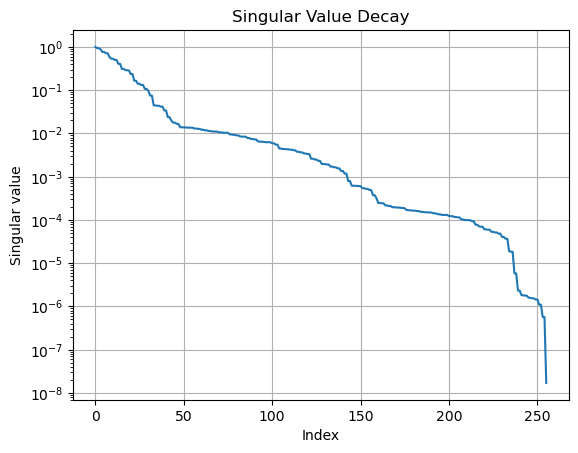

In [7]:
U, S, Vt = svd(A, full_matrices=False)


plt.figure()
plt.semilogy(S)
plt.title("Singular Value Decay")
plt.xlabel("Index")
plt.ylabel("Singular value")
plt.grid(True)
plt.show()

In [8]:
def tsvd_reconstruction(U, S, Vt, y_vec, k):
    Uk = U[:, :k]
    Sk = S[:k]
    Vk = Vt[:k, :]
    return Vk.T @ (Uk.T @ y_vec / Sk)


x_vec = x.flatten()
y_vec = y.flatten()

<function matplotlib.pyplot.show(close=None, block=None)>

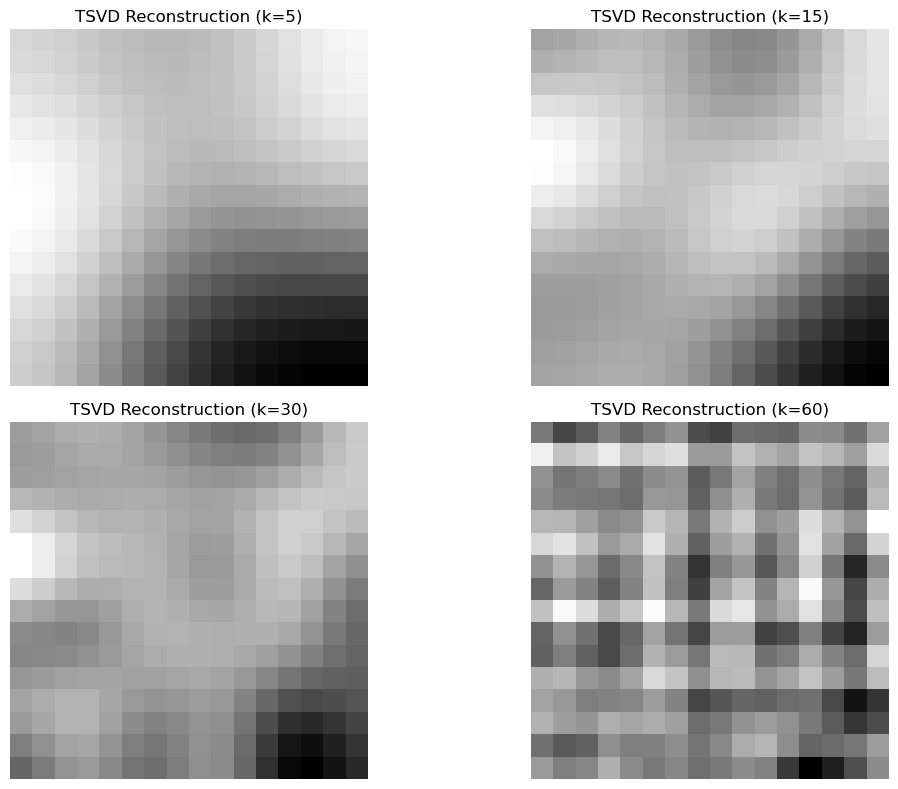

In [9]:
ks = [5, 15, 30, 60]


plt.figure(figsize=(12, 8))
for i, k in enumerate(ks):
    xk = tsvd_reconstruction(U, S, Vt, y_vec, k).reshape(n, n)
    plt.subplot(2, 2, i+1)
    plt.imshow(xk, cmap="gray")
    plt.title(f"TSVD Reconstruction (k={k})")
    plt.axis("off")


plt.tight_layout()
plt.show

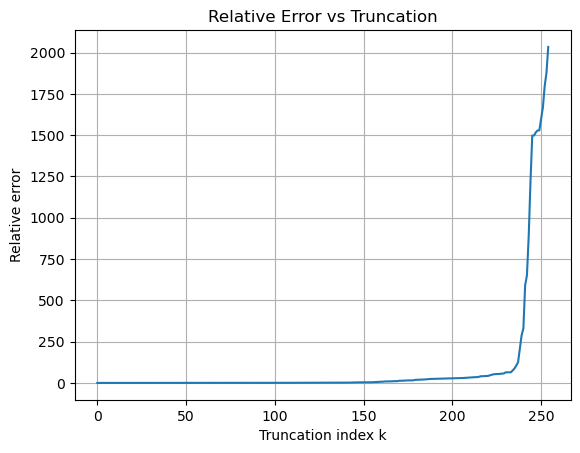

In [10]:
errors = []
for k in range(1, len(S)):
    xk = tsvd_reconstruction(U, S, Vt, y_vec, k)
    err = np.linalg.norm(x_vec - xk) / np.linalg.norm(x_vec)
    errors.append(err)


plt.figure()
plt.plot(errors)
plt.xlabel("Truncation index k")
plt.ylabel("Relative error")
plt.title("Relative Error vs Truncation")
plt.grid(True)
plt.show()